In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter
from scipy.stats import loguniform
import scipy
import pickle as pkl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/uoh_Project/train.csv')

In [ ]:
X=data.drop(['ID', 'TARGET'], axis=1)
y=data.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## Filter Features

In [ ]:
def get_constant_columns(data):
    # loop over all columns and use nunique() method in pandas to get different values of a feature
    # check if these values of a feature equal to 1
    constant_features = [feature for feature in data.columns if data[feature].nunique() == 1]
    return constant_features

def get_quasi_constant_columns(data,threshold):
    # an empty list for quasi constant feature
    quasi_constant_feat = []
    # iterate over every feature in train data
    for feature in data.columns:
        # find the predominant value, common in most data
        predominant = (data[feature].value_counts() / len(data)).sort_values(ascending=False).values[0]
        # evaluate the predominant feature: do more than threshold of the observations
        # show 1 value?
        if predominant > (threshold/100):
            # if yes, add the variable to the list
            quasi_constant_feat.append(feature)
    return(quasi_constant_feat)

def get_duplicate_columns(data):
    # create an empty dictionary, where we will store 
    # the groups of duplicates
    duplicated_feat_pairs = {}

    # create an empty list to collect features
    # that were found to be duplicated
    _duplicated_feat = []

    # iterate over every feature in our dataset:
    for i in range(0, len(data.columns)):
        # pick 1 feature
        feat_1 = data.columns[i]
        # check if this feature is already identified as duplicate feature or not
        # if not we can proceed further
        if feat_1 not in _duplicated_feat:
            # create an empty list as an entry for this feature in the dictionary:
            duplicated_feat_pairs[feat_1] = []
            # now, iterate over the remaining features of the dataset:
            for feat_2 in data.columns[i + 1:]:
                # check if this second feature is identical to the first one
                if data[feat_1].equals(data[feat_2]):
                    # if it is identical, append it to the list in the dictionary
                    duplicated_feat_pairs[feat_1].append(feat_2)
                    # and append it to our monitor list for duplicated variables
                    _duplicated_feat.append(feat_2)
    return _duplicated_feat

def get_filtered_columns(data,threshold):
    # first call function to get all constant features
    constantFeatures = get_constant_columns(data)
    # remove the constant features from data to avoid overlap in columns
    new_data = data.drop(constantFeatures,axis=1)
    
    # next call function to get all quasi constant features 
    quasiConstantFeatures = get_quasi_constant_columns(new_data,threshold)
    # remove the quasi constant features from data to avoid overlap in columns
    new_data = new_data.drop(quasiConstantFeatures, axis=1)
    
    # next call function to get all duplicate features
    duplicateFeatures = get_duplicate_columns(new_data)
    
    return (constantFeatures, quasiConstantFeatures, duplicateFeatures)

In [ ]:
constantFeatures, quasiConstantFeatures, duplicateFeatures = get_filtered_columns(X_train,99)

In [ ]:
finalFilteredColumns=[]
finalFilteredColumns.extend(constantFeatures)
finalFilteredColumns.extend(quasiConstantFeatures)
finalFilteredColumns.extend(duplicateFeatures)

In [ ]:
tableData=[['Constant Feature', len(constantFeatures)],
           ['Quasi Constant Features', len(quasiConstantFeatures)],
           ['Duplicate Features', len(duplicateFeatures)],
           ['-----------------------','-----------------'],
           ['TOTAL', len(finalFilteredColumns)]]
print(tabulate(tableData, headers=['Filtering Method','Features Filtered'], tablefmt="pretty"))

+-------------------------+-------------------+
|    Filtering Method     | Features Filtered |
+-------------------------+-------------------+
|    Constant Feature     |        47         |
| Quasi Constant Features |        171        |
|   Duplicate Features    |         6         |
| ----------------------- | ----------------- |
|          TOTAL          |        224        |
+-------------------------+-------------------+


In [ ]:
print(X_train.shape) # --> shape before filtering 
X_train=X_train.drop(finalFilteredColumns,axis=1)
print(X_train.shape) # --> shape after filtering 

(60816, 369)
(60816, 145)


In [ ]:
# For Test Data 
print(X_test.shape) # --> shape before filtering 
X_test=X_test.drop(finalFilteredColumns,axis=1)
print(X_test.shape) # --> shape after filtering 

(15204, 369)
(15204, 145)


## Remove Correlated Features Smartly

In [ ]:
def create_correlated_df(data):    
    corr_matrix = data.corr().abs().unstack().sort_values(ascending=False)
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'corr']
    # matrix contains feature pairs which are correlated more than 0.95
    corr_matrix = corr_matrix[(corr_matrix['corr'] < 1) & (corr_matrix['corr'] >= 0.95)]
    return corr_matrix

def find_correlated_groups(matrix):
    
    # find groups of correlated features

    grouped_feature_ls = []
    correlated_groups = []

    for feature in matrix.feature1.unique():

        if feature not in grouped_feature_ls:

            # find all features correlated to a single feature
            correlated_block = matrix[matrix.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]

            # append the block of features to the list
            correlated_groups.append(correlated_block)
    
    return correlated_groups

def smart_correlation(data,target):
    # get a correlated dataframe of each feature pair
    corr_mat = create_correlated_df(data)
    
    # next we find features which are correlated 
    correlated_features_groups = find_correlated_groups(corr_mat)
    
    features_with_high_corr = []
    # loop over each correlated groups that we have aquired
    for i in range(len(correlated_features_groups)):
        corr_group = correlated_features_groups[i]
        # get all features from feature1 col and feature2 col
        features = list(corr_group['feature2'].unique())+list(corr_group['feature1'].unique())
        # build a Pipeline with SMOTE and random forest classifier
        rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
        # SMOTE help oversample the data with creating synthetic points for minority class, 
        # rather than normal oversampling, which just copies the minority class data points again
        steps = [('oversampling', SMOTE()), ('model', rf)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(data[features],target)
        # get feature importance of all the features in the correlated group
        importance = pd.concat([pd.Series(features),
                                pd.Series(rf.feature_importances_)],
                               axis=1)
        importance.columns = ['feature', 'importance']
        # sort features by importance, most important first
        importance=importance.sort_values(by='importance', ascending=False)
        # remove the most important feature from the list of features in that group
        features.remove(importance.feature[0])
        # append the remaining features as features to be removed
        features_with_high_corr.extend(features)

    return list(set(features_with_high_corr))

In [ ]:
features_with_high_corr = smart_correlation(X_train,y_train)

In [ ]:
print(X_train.shape) # --> shape before removing correlated features 
X_train = X_train.drop(features_with_high_corr,axis=1)
print(X_train.shape) # --> shape after removing correlated features 

(60816, 145)
(60816, 96)


In [ ]:
# For test data
print(X_test.shape) # --> shape before removing correlated features 
X_test = X_test.drop(features_with_high_corr,axis=1)
print(X_test.shape) # --> shape after removing correlated features 

(15204, 145)
(15204, 96)


## Do Feature Engineering and Log transformation and Reduce Cardinality 

In [ ]:
def feature_engineering(data):
    # add a new feature to store count number of zeroes across a row
    data['count_zeroes'] = (data == 0).astype(int).sum(axis=1)
    
    # add a new feature to store count number of non zeroes across a rows
    data['count_non_zeroes'] = (data != 0).astype(int).sum(axis=1)
    
    # add a new feature to store if var3 value is mode (most common nationality)
    data['var3_mode'] = [1 if i==2 else 0 for i in data.var3]
    
    # replace -999999 outlier in var3 by mode value
    data.var3 = data.var3.replace(to_replace=-999999, value=2)
    
    # add a new feature to capture customers with var15 below 23
    data['var15_below_23'] = [1 if i<23 else 0 for i in data.var15]
    
    # add a new feature to store the insights for var36 that the value was 99 (outlier)
    data['var36_is_99'] = [1 if i==99 else 0 for i in data.var36]
    
    # replace this 99 in var36 with the value 2 as calculated through KNNImputer
    data.var36 = data.var36.replace(to_replace=99, value=2)
    
    # add a new feature to capture the mode value for var38
    data['var38_mode'] = [1 if i==117310.979016494 else 0 for i in data.var38]
    
    # add a new feature to capture is saldo_medio_var5_ult3 is 0 or not
    data['sal_medio_var5_ult3_is_0'] = [1 if i==0.0 else 0 for i in data.saldo_medio_var5_ult3]
    
    # add a new feature to capture if saldo_var30 is 0 or 3 or something else
    data['sal_var30_is_0_3'] = [1 if i in [0,3] else 0 for i in data.saldo_var30]
    
    # for 'num' keyword features we saw that there was pattern of divisible by 3
    # hence we take sum of those features which are non-zero and divisble by 3 across each row
    numKeywordFeatures = [column for column in data.columns if 'num' in column]
    data['Feat_divisible_by_3']=((data[numKeywordFeatures]%3==0) & (data[numKeywordFeatures]!=0)).astype(int).sum(axis=1)
    
    # add Kmean cluster features
    clusterSizes= [2,4,6,8,10]
    data = kmeanFeat(data, clusterSizes)
    return data

def get_log_on_data(data):
    # while EDA it was evident to take log on var38 to better Gaussian like distribution
    data['var38_log'] = np.log(data.var38)
    data = data.drop(['var38'], axis=1)
    
    # for features with keyword 'imp' we decided to use the log of the values
    impKeywordFeatures = [column for column in data.columns if 'imp' in column]
    for feat in impKeywordFeatures:
        new_feat = feat + '_log'
        data[new_feat] = [val if val <= 0 else np.log(val) for val in data[feat]]
    data = data.drop(impKeywordFeatures, axis=1)
    
    # for features with keyword 'saldo' we decided to use the log of the values
    saldoKeywordFeatures = [column for column in data.columns if 'saldo' in column]
    for feat in saldoKeywordFeatures:
        new_feat = feat+'_log'
        data[new_feat] = [val if val <= 0 else np.log(val) for val in data[feat]]
    data = data.drop(saldoKeywordFeatures, axis=1)
    
    return data

def kmeanFeat(data, clusterSizes):
    cols=data.columns
    # Standardize the data
    sc=StandardScaler()
    dataCopy=data.copy()
    dataCopy.loc[:,cols]= sc.fit_transform(dataCopy.loc[:,cols])
    
    # loop over cluster sizes and find appropriate clusters using each cluster size
    for size in clusterSizes:
        f_name='K-mean-cluster-'+str(size)
        kmeans = KMeans(n_clusters=size,random_state=42)
        
        # create a new feature for each cluster size
        data[f_name] = kmeans.fit_predict(dataCopy)
    
    return data 

In [ ]:
def cumulatively_categorise(column,threshold=0.90,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: str(x) if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    else:
        #Return only the transformed column if return_categories=False
        return new_column
    
def reduceCardinality(data):
    # get all features with 'num' keyword in its name
    numKeywordFeatures = [i for i in data.columns if 'num' in i ]
    
    featCardinalitydict = {}
    for feat in numKeywordFeatures:
        transformed_column, new_category_list=cumulatively_categorise(data[feat],return_categories_list=True)
        featCardinalitydict[feat] = new_category_list
        data[feat] = transformed_column
        
    for feat in featCardinalitydict.keys():
        data[feat] = data[feat].astype(str)
        
    return data, featCardinalitydict

In [ ]:
# 1. After feature engineering we have this dataset 'X_train1'
X_train1 = feature_engineering(X_train.copy())

# 2. Then I try to reduce the cardinality for 'num' keywords feature 
X_train2, featCardinalitydict = reduceCardinality(X_train1.copy())

# 3. Now I take log on specific dataset to create a all new dataset 'newData_redCardwithLog'
X_train3 = get_log_on_data(X_train2.copy())

In [ ]:
def reduceCardForTest(data,featCardinalitydict):
    for feat in featCardinalitydict.keys():
        data[feat] = [val if val in featCardinalitydict[feat] else 'Other' for val in data[feat]]
        data[feat] = data[feat].astype(str)
    return data

In [ ]:
# 1. After feature engineering we have this dataset 'X_test1'
X_test1 = feature_engineering(X_test.copy())

# 2. Then I try to reduce the cardinality for 'num' keywords feature
X_test2 = reduceCardForTest(X_test1.copy(), featCardinalitydict)

# 3. Now I take log on specific dataset to create a all new dataset 'newData_redCardwithLog'
X_test3 = get_log_on_data(X_test2.copy())

## One hot encoding

In [ ]:
def oneHotEncoding(train,test):
    ## get those features which have unique value less than 16 to encode and greater than 1
    features_to_encode = []
    for col in train.columns:
        if (train[col].nunique()<=15) & (train[col].nunique()>=2) & ('K-mean' not in col):
            features_to_encode.append(col)

    for feat in features_to_encode:
        dataTemp = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
        train = pd.concat([train, dataTemp], axis=1)
    
    # next we remove the features that are now one hot encoded
    for i in features_to_encode:
        train.drop(i,axis=1,inplace=True)

    for feat in features_to_encode:
        dataTemp = pd.get_dummies(test[feat], prefix=feat, drop_first=True)
        test = pd.concat([test, dataTemp], axis=1)
    
    # next we remove the features that are now one hot encoded
    for i in features_to_encode:
        test.drop(i,axis=1,inplace=True)
        
    return train,test

In [ ]:
def one_hot_encoding(train,test):
    """
    one hot encodes all the features in col array in all X dataset
    """
    features_to_encode = []
    for col in train.columns:
        if (train[col].nunique()<=10) & (train[col].nunique()>=2) & ('K-mean' not in col):
            features_to_encode.append(col)
    
    ohe = OneHotEncoder(sparse=True,handle_unknown='ignore')
    ohe.fit(train.loc[:,features_to_encode])
    feature_names = list(ohe.get_feature_names(input_features=features_to_encode))
    features = list(train.drop(features_to_encode,axis=1).columns)
    features.extend(feature_names)

    #train
    
    df = train.copy()
    temp = ohe.transform(df[features_to_encode])
    df.drop(features_to_encode,axis=1,inplace=True)
    train = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
    train = train.loc[:,~train.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)


    #test
    df = test.copy()
    temp = ohe.transform(df[features_to_encode])
    df.drop(features_to_encode,axis=1,inplace=True)
    test = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()
    test = test.loc[:,~test.columns.duplicated(keep='first')] #removing duplicated columns (duplicated columsn were seen)

    return train,test

In [ ]:
X_train1_ohe,X_test1_ohe = one_hot_encoding(X_train1.copy(),X_test1.copy())
X_train2_ohe,X_test2_ohe = oneHotEncoding(X_train2.copy(),X_test2.copy())
X_train3_ohe,X_test3_ohe = oneHotEncoding(X_train3.copy(),X_test3.copy())

In [ ]:
print(X_train1_ohe.shape)
print(X_train2_ohe.shape)
print(X_train3_ohe.shape)
print(X_test1_ohe.shape)
print(X_test2_ohe.shape)
print(X_test3_ohe.shape)

(60816, 225)
(60816, 167)
(60816, 167)
(15204, 225)
(15204, 167)
(15204, 167)


## Save the Training and Test data till here

In [ ]:
X_train1_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train1_ohe.pkl")
X_train2_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train2_ohe.pkl")
X_train3_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_train3_ohe.pkl")
X_test1_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test1_ohe.pkl")
X_test2_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test2_ohe.pkl")
X_test3_ohe.to_pickle("/content/drive/MyDrive/uoh_Project/X_test3_ohe.pkl")

In [3]:
X_train1_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train1_ohe.pkl")
X_train2_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train2_ohe.pkl")
X_train3_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_train3_ohe.pkl")
X_test1_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test1_ohe.pkl")
X_test2_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test2_ohe.pkl")
X_test3_ohe = pd.read_pickle("/content/drive/MyDrive/uoh_Project/X_test3_ohe.pkl")

In [ ]:
y_train.to_pickle("/content/drive/MyDrive/uoh_Project/y_train.pkl")
y_test.to_pickle("/content/drive/MyDrive/uoh_Project/y_test.pkl")

In [4]:
y_train = pd.read_pickle("/content/drive/MyDrive/uoh_Project/y_train.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/uoh_Project/y_test.pkl")

## Standardize the data

In [5]:
sc=StandardScaler()
sc.fit(X_train1_ohe)
X_train1_ohe = sc.transform(X_train1_ohe)
X_test1_ohe = sc.transform(X_test1_ohe)
print(X_train1_ohe.shape)
print(X_test1_ohe.shape)

(60816, 225)
(15204, 225)


In [6]:
sc=StandardScaler()
sc.fit(X_train2_ohe)
X_train2_ohe = sc.transform(X_train2_ohe)
X_test2_ohe = sc.transform(X_test2_ohe)
print(X_train2_ohe.shape)
print(X_test2_ohe.shape)

(60816, 167)
(15204, 167)


In [7]:
sc=StandardScaler()
sc.fit(X_train3_ohe)
X_train3_ohe = sc.transform(X_train3_ohe)
X_test3_ohe = sc.transform(X_test3_ohe)
print(X_train3_ohe.shape)
print(X_test3_ohe.shape)

(60816, 167)
(15204, 167)


## Modelling

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from numpy import mean
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV  ## as linear classifier dont have predict proba using the calibratedclassifier

In [9]:
def plotROCcurve(y_train,y_pred_train,y_test,y_pred_test):
    fpr, tpr, tr_thresholds = roc_curve(y_train, y_pred_train)
    plt.plot(fpr, tpr, label="Train AUC ="+str(auc(fpr,tpr)))

    fpr, tpr, tr_thresholds = roc_curve(y_test, y_pred_test)
    plt.plot(fpr, tpr, label="Test AUC ="+str(auc(fpr,tpr)))

    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-Curve")
    plt.grid(True)
    plt.show()

https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [10]:
def plotConfusionM(X_train, X_test, y_train, y_test, model):
    f, axes = plt.subplots(1, 2,sharex=True, figsize=(10,5))
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    f.suptitle('Confusion Matrix Plot')

    cf_matrix = confusion_matrix(y_train, y_pred_train)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    axes[0].set_title('On Train Data')
    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[0])

    
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    axes[1].set_title('On Test Data')
    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[1])

### 1. Grid Search Weighted Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


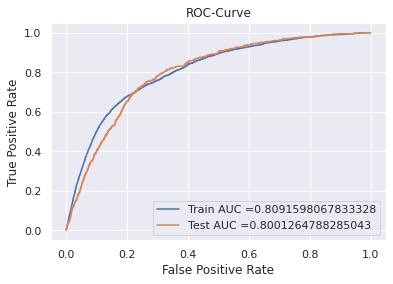

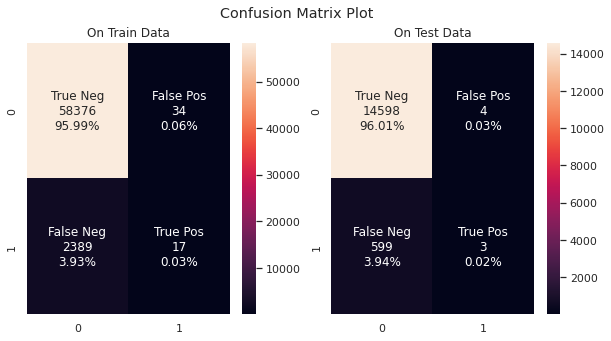

In [ ]:
model = LogisticRegression()
model.fit(X_train3_ohe, y_train)
y_pred_train = model.predict_proba(X_train3_ohe) [:,1]
y_pred_test = model.predict_proba(X_test3_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model)

In [ ]:
# define model
model = LogisticRegression(solver='lbfgs',max_iter = 1000)
# define grid
balance = [{0:10,1:1}, {0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:20}, {0:1,1:50}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv,\
scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train3_ohe, y_train)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.804036 using {'class_weight': {0: 1, 1: 20}}
0.793819 (0.006756) with: {'class_weight': {0: 10, 1: 1}}
0.796257 (0.006095) with: {'class_weight': {0: 1, 1: 1}}
0.801344 (0.005251) with: {'class_weight': {0: 1, 1: 5}}
0.803238 (0.005204) with: {'class_weight': {0: 1, 1: 10}}
0.804036 (0.005169) with: {'class_weight': {0: 1, 1: 20}}
0.803259 (0.005345) with: {'class_weight': {0: 1, 1: 50}}


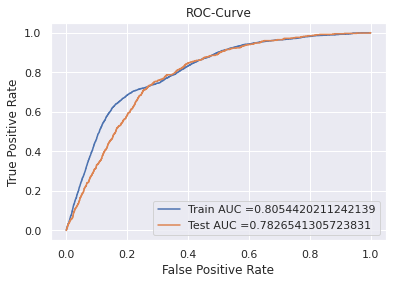

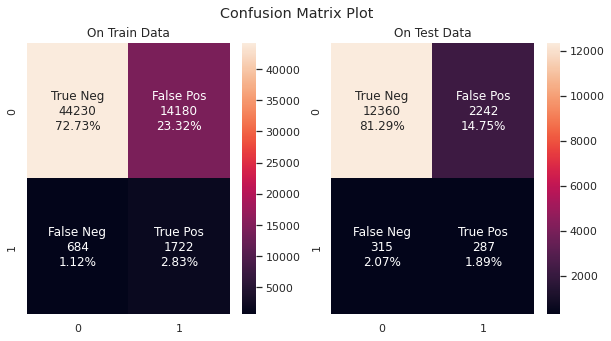

In [ ]:
model = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model.fit(X_train1_ohe, y_train)
y_pred_train = model.predict_proba(X_train1_ohe) [:,1]
y_pred_test = model.predict_proba(X_test1_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model)

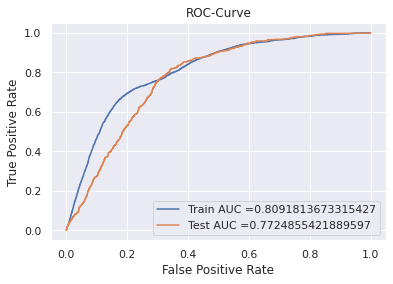

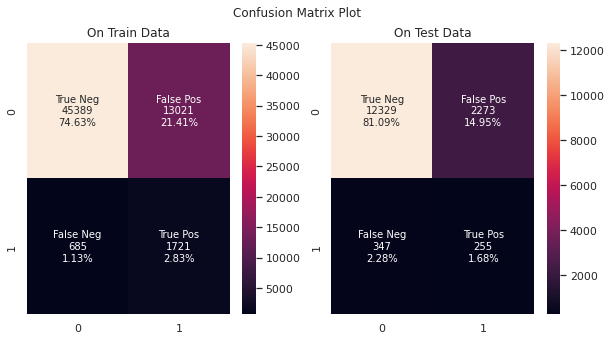

In [ ]:
model = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model.fit(X_train2_ohe, y_train)
y_pred_train = model.predict_proba(X_train2_ohe) [:,1]
y_pred_test = model.predict_proba(X_test2_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model)

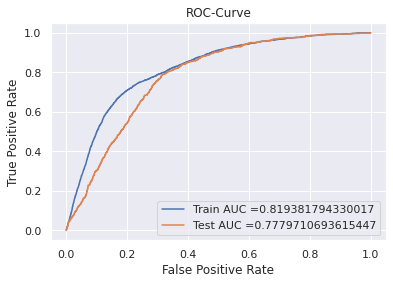

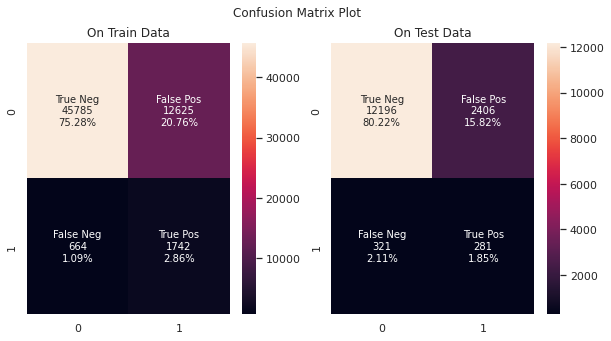

In [ ]:
model = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 20}, max_iter = 1000)
model.fit(X_train3_ohe, y_train)
y_pred_train = model.predict_proba(X_train3_ohe) [:,1]
y_pred_test = model.predict_proba(X_test3_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model)

### 3. Grid Search Weighted Support Vector Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


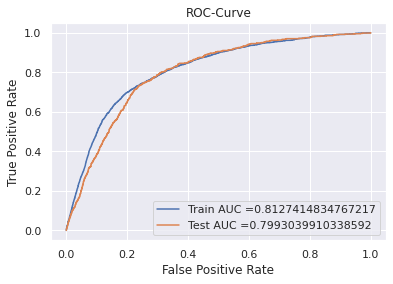

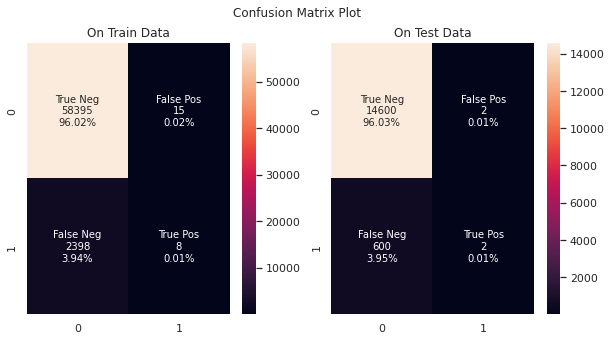

In [ ]:
model = CalibratedClassifierCV(base_estimator=LinearSVC(), cv=5)
model.fit(X_train3_ohe, y_train)
y_pred_train = model.predict_proba(X_train3_ohe) [:,1]
y_pred_test = model.predict_proba(X_test3_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model)

In [ ]:
# grid search class weights with svm for imbalance classification

# define model
model = LinearSVC()
# define grid
balance = [{0:2,1:1}, {0:1,1:1}, {0:1,1:2}, {0:1,1:4}, {0:1,1:6}, {0:1,1:8}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train3_ohe, y_train)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


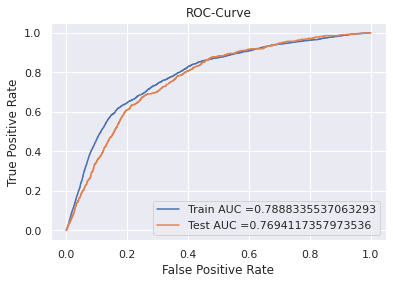

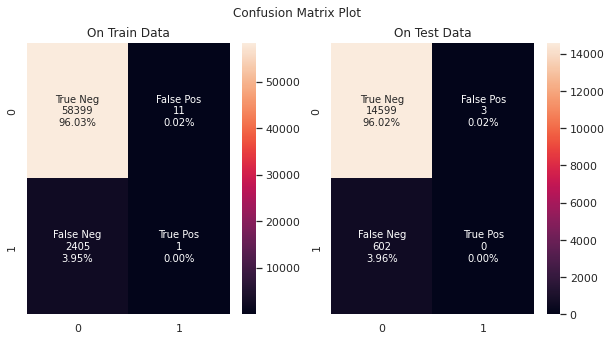

In [13]:
model = CalibratedClassifierCV(LinearSVC(class_weight={0: 1, 1: 10}),cv=3)
model.fit(X_train1_ohe, y_train)
y_pred_train = model.predict_proba(X_train1_ohe) [:,1]
y_pred_test = model.predict_proba(X_test1_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


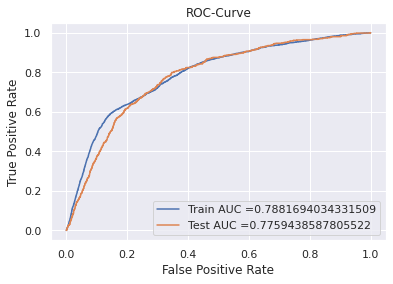

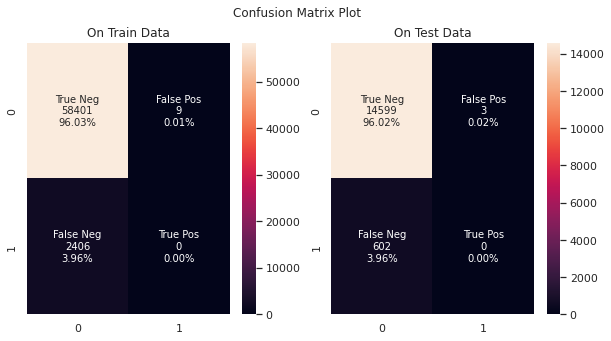

In [14]:
model = CalibratedClassifierCV(LinearSVC(class_weight={0: 1, 1: 10}),cv=3)
model.fit(X_train2_ohe, y_train)
y_pred_train = model.predict_proba(X_train2_ohe) [:,1]
y_pred_test = model.predict_proba(X_test2_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


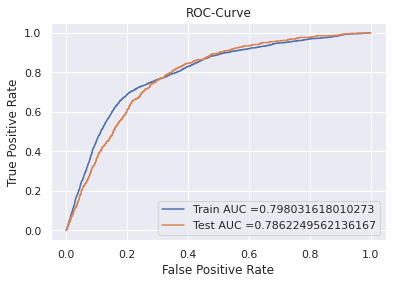

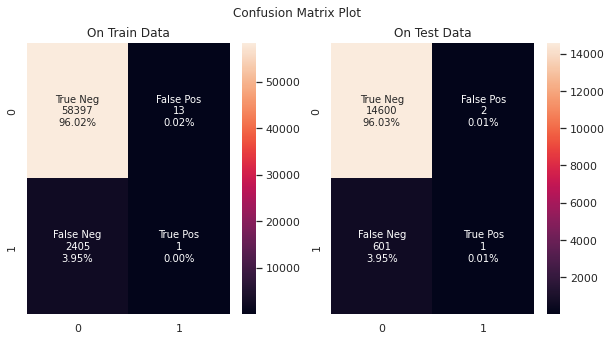

In [15]:
model = CalibratedClassifierCV(LinearSVC(class_weight={0: 1, 1: 10}),cv=3)
model.fit(X_train2_ohe, y_train)
y_pred_train = model.predict_proba(X_train2_ohe) [:,1]
y_pred_test = model.predict_proba(X_test2_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model)

### 3. Grid Search Weighted Decision Tree

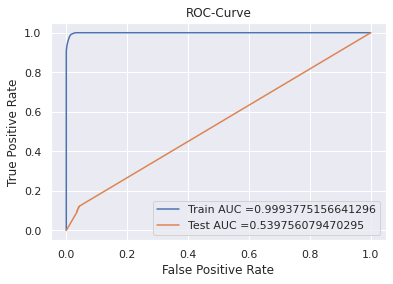

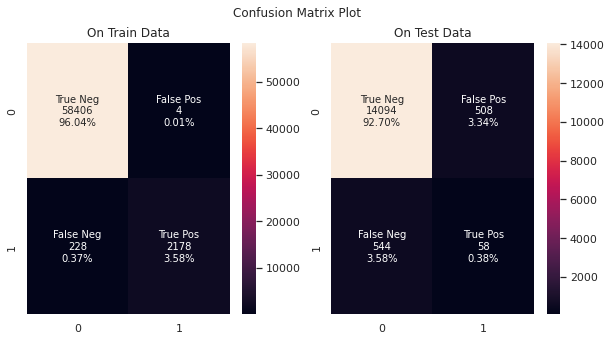

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train3_ohe, y_train)
y_pred_train = model.predict_proba(X_train3_ohe) [:,1]
y_pred_test = model.predict_proba(X_test3_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model)

In [ ]:
# grid search class weights with decision tree for imbalance classification
# define model
model = DecisionTreeClassifier()
# define grid
balance = [{0:10,1:1}, {0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:20}, {0:1,1:50}]
max_depth = [5,10,15,20,25]
param_grid = dict(class_weight=balance, max_depth=max_depth)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train3_ohe, y_train)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.814062 using {'class_weight': {0: 1, 1: 5}, 'max_depth': 5}
0.798195 (0.013218) with: {'class_weight': {0: 10, 1: 1}, 'max_depth': 5}
0.813073 (0.012336) with: {'class_weight': {0: 10, 1: 1}, 'max_depth': 10}
0.799115 (0.013293) with: {'class_weight': {0: 10, 1: 1}, 'max_depth': 15}
0.773713 (0.016481) with: {'class_weight': {0: 10, 1: 1}, 'max_depth': 20}
0.732402 (0.020503) with: {'class_weight': {0: 10, 1: 1}, 'max_depth': 25}
0.809819 (0.012840) with: {'class_weight': {0: 1, 1: 1}, 'max_depth': 5}
0.799886 (0.016991) with: {'class_weight': {0: 1, 1: 1}, 'max_depth': 10}
0.739374 (0.019429) with: {'class_weight': {0: 1, 1: 1}, 'max_depth': 15}
0.685776 (0.019073) with: {'class_weight': {0: 1, 1: 1}, 'max_depth': 20}
0.651713 (0.018377) with: {'class_weight': {0: 1, 1: 1}, 'max_depth': 25}
0.814062 (0.013811) with: {'class_weight': {0: 1, 1: 5}, 'max_depth': 5}
0.760831 (0.017325) with: {'class_weight': {0: 1, 1: 5}, 'max_depth': 10}
0.696772 (0.018440) with: {'class_weight':

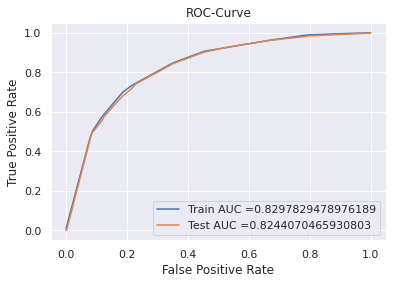

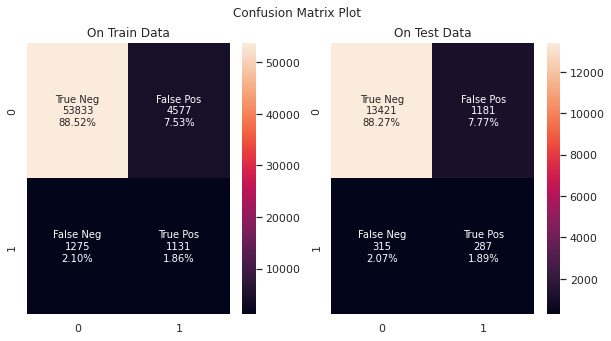

In [ ]:
model = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model.fit(X_train1_ohe, y_train)
y_pred_train = model.predict_proba(X_train1_ohe) [:,1]
y_pred_test = model.predict_proba(X_test1_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train1_ohe, X_test1_ohe, y_train, y_test, model)

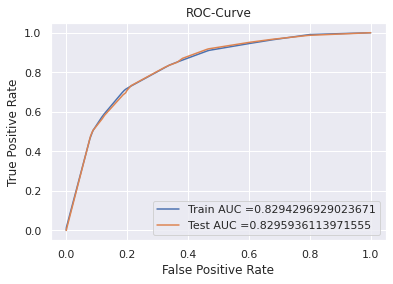

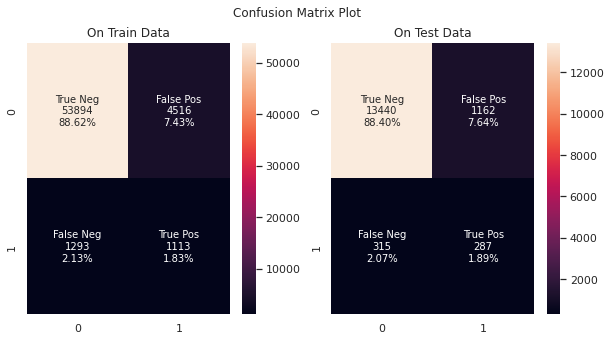

In [ ]:
model = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model.fit(X_train2_ohe, y_train)
y_pred_train = model.predict_proba(X_train2_ohe) [:,1]
y_pred_test = model.predict_proba(X_test2_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train2_ohe, X_test2_ohe, y_train, y_test, model)

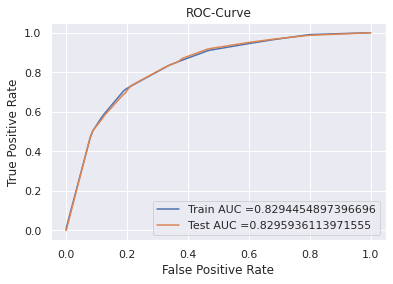

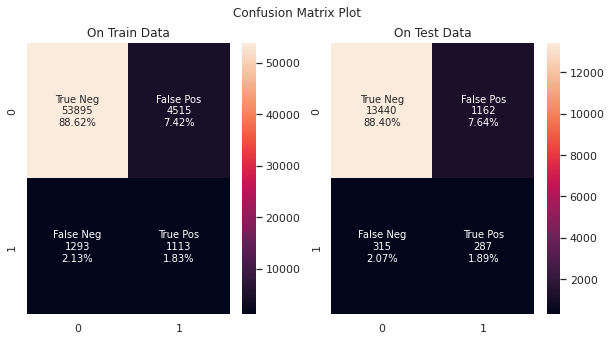

In [ ]:
model = DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=5)
model.fit(X_train3_ohe, y_train)
y_pred_train = model.predict_proba(X_train3_ohe) [:,1]
y_pred_test = model.predict_proba(X_test3_ohe) [:,1]
plotROCcurve(y_train,y_pred_train,y_test,y_pred_test)
plotConfusionM(X_train3_ohe, X_test3_ohe, y_train, y_test, model)

In [19]:
from beautifultable import BeautifulTable
table = BeautifulTable(precision=4,maxwidth=80)
table.columns.header = ["Model_Name", "Dataset", "AUC Score (Train)", "AUC Score (Test)"]
table.rows.append(["Cost Sensitive LR", 1, 0.8054, 0.7826])
table.rows.append(["Cost Sensitive LR", 2, 0.8091, 0.7724])
table.rows.append(["Cost Sensitive LR", 3, 0.8194, 0.7779])
table.rows.append(["Cost Sensitive L-SVC", 1, 0.7888, 0.7694])
table.rows.append(["Cost Sensitive L-SVC", 2, 0.7881, 0.7759])
table.rows.append(["Cost Sensitive L-SVC", 3, 0.7980, 0.7862])
table.rows.append(["Cost Sensitive DT", 1, 0.8298, 0.8244])
table.rows.append(["Cost Sensitive DT", 2, 0.8294, 0.8296])
table.rows.append(["Cost Sensitive DT", 3, 0.8294, 0.8296])
print(table)

+----------------------+---------+-------------------+------------------+
|      Model_Name      | Dataset | AUC Score (Train) | AUC Score (Test) |
+----------------------+---------+-------------------+------------------+
|  Cost Sensitive LR   |    1    |      0.8054       |      0.7826      |
+----------------------+---------+-------------------+------------------+
|  Cost Sensitive LR   |    2    |      0.8091       |      0.7724      |
+----------------------+---------+-------------------+------------------+
|  Cost Sensitive LR   |    3    |      0.8194       |      0.7779      |
+----------------------+---------+-------------------+------------------+
| Cost Sensitive L-SVC |    1    |      0.7888       |      0.7694      |
+----------------------+---------+-------------------+------------------+
| Cost Sensitive L-SVC |    2    |      0.7881       |      0.7759      |
+----------------------+---------+-------------------+------------------+
| Cost Sensitive L-SVC |    3    |    